In [10]:
!pip install -q colour-science
import numpy as np
import matplotlib.pyplot as plt
import cv2
import colour
from copy import deepcopy

In [11]:
def find_circles(paleta):
    """
    Finds circles in the given palette image
    Returns the (x,y) coordinates and the radius of each circle
    """
    gray = cv2.cvtColor(paleta, cv2.COLOR_RGB2GRAY)
    detected_circles = cv2.HoughCircles(gray, 
                        cv2.HOUGH_GRADIENT, 1, 20, param1 = 100,
                    param2 = 25, minRadius = 1, maxRadius = 25)

    if detected_circles is not None:
        detected_circles = np.uint16(np.around(detected_circles))

    return detected_circles[0]

def getColorsMatrix(paleta,detected_circles):
    """
    Gets the median of the color of each circle
    Returns median RGB values for each circle in the image
    """
    my_circles = deepcopy(detected_circles)
    circles_column_idx = np.argsort(my_circles[:,0])
    circ_sorted_x = deepcopy(my_circles[circles_column_idx,:])

    circ_split = np.array_split(circ_sorted_x,4)

    circ_sorted_y = np.zeros_like(circ_split)
    for k in range(len(circ_split)):
        circles_row_idx = np.argsort(circ_split[k][:,1])
        circ_sorted_y[k] = deepcopy(circ_split[k][circles_row_idx,:])
    
    rows,cols,_ = circ_sorted_y.shape
    my_circles = np.reshape(circ_sorted_y,(rows*cols,_))

    median_array = np.zeros((len(my_circles),3))
    for k in range(len(my_circles)):
        (x,y,r) = my_circles[k]
        
        median_r = np.median(paleta[y-(r//2):y+(r//2),x-(r//2):x+(r//2),0])
        median_g = np.median(paleta[y-(r//2):y+(r//2),x-(r//2):x+(r//2),1])
        median_b = np.median(paleta[y-(r//2):y+(r//2),x-(r//2):x+(r//2),2])
        
        median_array[k] = (median_r,median_g,median_b)
    
    return my_circles,median_array

In [81]:
path_original = "/content/drive/MyDrive/Mi_FFI/PruebaColour/Copia de CALIBRACION.JPG"
path_mod = "/content/drive/MyDrive/Mi_FFI/PruebaColour/Edit de CALIBRACION.png"

img_original = cv2.cvtColor(cv2.imread(path_original), cv2.COLOR_BGR2RGB)
img_mod = cv2.cvtColor(cv2.imread(path_mod), cv2.COLOR_BGR2RGB)

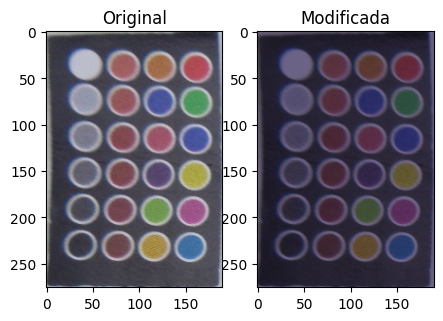

In [82]:
plt.figure(figsize=(5,5), dpi=100)
plt.subplot(1,2,1); plt.title("Original")
plt.imshow(img_original)
plt.subplot(1,2,2); plt.title("Modificada")
plt.imshow(img_mod)
plt.show()

In [90]:
_,median_orig = getColorsMatrix(img_original, find_circles(img_original))
_,median_mod = getColorsMatrix(img_mod, find_circles(img_mod))

height,width,ch = img_mod.shape
vec_mod = np.reshape(img_mod, (height*width, ch))

methods = sorted(colour.COLOUR_CORRECTION_METHODS)
diferencias = np.zeros((3, 24, 3), dtype = float)

for k, method in enumerate(methods):
    # print(method)
    vec_cal = colour.colour_correction(vec_mod, median_mod, median_orig,
                                       method=method)

    vec_cal[vec_cal>255] = 255
    vec_cal[vec_cal<0] = 0

    img_cal = np.uint8(np.reshape(vec_cal, (height, width, ch)))

    _, median_cal = getColorsMatrix(img_cal, find_circles(img_cal))

    absdiff = np.abs(median_orig - median_cal)
    # print(absdiff,'\n')
    diferencias[k] = absdiff

In [98]:
(diferencias[0] == diferencias[1]).all()

True

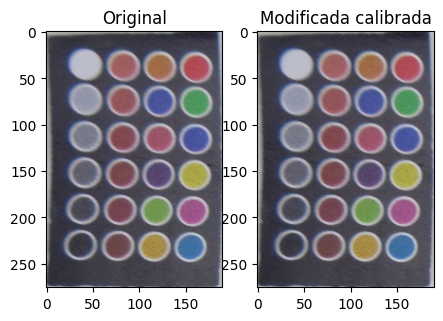

In [88]:
plt.figure(figsize=(5,5), dpi=100)
plt.subplot(1,2,1); plt.title("Original")
plt.imshow(img_original)
plt.subplot(1,2,2); plt.title("Modificada calibrada")
plt.imshow(img_cal)
plt.show()